In [1]:
import os
import sys
import time
import math
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
from glob import glob
from datetime import date
import mne

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Functions

### Subjects

In [5]:
## Mice that have at least one recovery state ##
sub_dirs = {
    '521885': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\estim1_2020-07-09_14-23-49\experiment1\recording1',
    '521886': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\estim1_2020-07-16_13-37-02\experiment1\recording1',
    '521887': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521887\estim1_2020-07-30_11-25-05\experiment1\recordingfull',
    '543393': r'F:\EEG_exp\mouse543393\estim1_2020-08-20_13-24-53\experiment1\recording1',
    '543394': r'F:\EEG_exp\mouse543394\estim1_2020-08-27_14-32-00\experiment1\recording1',
    '543395': r'F:\EEG_exp\mouse543395\estim1_2020-09-03_13-19-42\experiment1\recording1',
    '543396': r'F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1',
    '546655': r'F:\EEG_exp\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
    '551400': r'F:\EEG_exp\mouse551400\estim_vis_2021-01-22_11-07-12\experiment1\recording1',
    '551399': r'F:\EEG_exp\mouse551399\estim_2021-01-28_13-59-09\experiment1\recording1',
    '551397': r'F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1',
    '569062': r'F:\EEG_exp\mouse569062\estim_vis_2021-02-18_11-17-51\experiment1\recording1',
    '569068': r'F:\EEG_exp\mouse569068\estim_vis_2021-03-04_10-51-38\experiment1\recording1',
    '569069': r'F:\EEG_exp\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1',
    '569064': r'F:\EEG_exp\mouse569064\estim_vis_2021-04-08_10-28-24\experiment1\recording1',
    '569073': r'F:\EEG_exp\mouse569073\estim_vis_2021-04-15_10-27-22\experiment1\recording1',
    '571618': r'F:\EEG_exp\mouse571618\estim1_2021-04-29_12-28-54\experiment1\recording1',
}

## Sweep ids for each brain state
brain_states = {
    '521885': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [], 'recovery_30-60min': []},
    '521886': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []},
    '521887': {'awake': [0, 1], 'anesthetized': [2, 3, 4], 'recovery_0-30min': [5, 6, 7], 'recovery_30-60min': []},
    '543393': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5], 'recovery_0-30min': [6, 7, 8], 'recovery_30-60min': []},
    '543394': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5], 'recovery_0-30min': [6, 7, 8], 'recovery_30-60min': []},
    '543395': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5, 6], 'recovery_0-30min': [7, 8, 9], 'recovery_30-60min': []},
    '543396': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []},
    '546655': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []}, # sweep 3 was incomplete
    '551400': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '551399': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '551397': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '569062': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []},
    '569068': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '569069': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '569064': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '569073': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '571618': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [], 'recovery_30-60min': []},
}

#### Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Load experiments

In [7]:
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: ele

In [8]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'
# plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\PCI_windows'

### Load eeg data and gather stim-evoked traces

In [1]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 1. # s, look at 1 s post-stim

apply_mask = True
apply_hpass = True
apply_car = True

In [10]:
start = time.time()

estim_traces = {}
sub_good_chs = {}
PCI_stim_amp = {}
multi_amps_mice = []
for mousei, expi in sub_exp.items():
    print(mousei)
    
    ## Grab exp metadata from Zap_Zip-log_exp ##
    expi_meta = zzmetadata[(
        (zzmetadata['mouse_name'].str.contains(expi.mouse)) &
        (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(expi.experiment_folder))))
    )].squeeze()
    
    ## Get bad_ch_list from metadata ##
    badchstr = expi_meta['EEG bad_channels'].replace(' ','')
    bad_ch_list = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_ch_list.append(int(char))
    
    ## Get PCI_stim_amp from metadata ##
    currentstr = expi_meta['Current (uA)'].replace(' ','')
    currents_list = []
    for char in currentstr.split('/'):
        if char.isdecimal():
            currents_list.append(int(char))
    if len(currents_list) > 1:
        PCI_stim_amp[mousei] = currents_list[1]
    elif len(currents_list) == 1:
        PCI_stim_amp[mousei] = currents_list[0]
    else:
        print('No stim current listed in Zap_Zip-log_exp')
    
    # load stim log
#     stim_log, good_chs = expi.qualitycheck_trials_chs()
    stim_log = pd.read_csv(expi.stimulus_log_file)
    amps_list = np.sort(stim_log.loc[stim_log.stim_type == 'biphasic', 'parameter'].unique())
    if len(amps_list) > 1:
        multi_amps_mice.append(mousei)
    
    # load data
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(0, datai.shape[1])
    good_chs = np.array([x for x in eegchs if x not in bad_ch_list])
    
    # mask estim artifact
    if apply_mask:
        mask_samples = int(0.002 * expi.ephys_params['EEG']['sample_rate'])
        for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
            val = find_nearest_ind(tsi, etime) - 2
            datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
            
    ## Apply high-pass filter ##
    if apply_hpass:
        hpb, hpa = signal.butter(3, 0.1/(expi.ephys_params['EEG']['sample_rate']/2), btype='highpass')
        datai = signal.filtfilt(hpb, hpa, datai, axis=0)
    
    # get evoked traces
    estim_traces[mousei] = {}
    
    for ampi in amps_list:
        estim_traces[mousei][str(ampi)] = {}
        for statei, sweeps in brain_states[mousei].items():
            if sweeps:
                traces = []
                goodchlist = []
                for sweepi in sweeps:
                    events = get_stim_events(stim_log, 'biphasic', ampi, sweepi)
                    if len(events) == 0:
#                         print('{}, {}, sweep {:d}: no good trials found'.format(st_type, str(ampi), sweepi))
                        continue
#                     print('{}, {}, sweep {:d}: {:d} good trials'.format(st_type, str(ampi), sweepi, len(events)))
                    event_traces, event_ts = get_evoked_traces(
                        datai,
                        tsi,
                        events,
                        before_event,
                        after_event,
                        expi.ephys_params['EEG']['sample_rate']
                    )
                    traces.append(event_traces)
                
                if not traces:
                    print('{} {}: no good trials found'.format(statei, str(ampi)))
                    continue
                state_traces = np.concatenate(traces, axis=2)
                
                # apply common avg
                if apply_car:
                    state_traces = state_traces - np.mean(state_traces[:, good_chs, :], axis=1)[:,None,:]
                    
                # apply lowpass filter
                filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')
                
                estim_traces[mousei][str(ampi)][statei] = [event_ts, signal.filtfilt(filtb, filta, state_traces, axis=0)]
    sub_good_chs[mousei] = good_chs
            
    del datai
    del tsi
    del stim_log

end = time.time()
print('Time to analyze: {:.2f} min'.format((end - start) / 60))

521885
521886
521887
543393
543394
543395
543396
546655
551400
551399
551397
569062
569068
569069
569064
569073
571618
Time to analyze: 14.62 min


### Calculate PCIst, match trial numbers of states (only for optimal stim amp)

In [11]:
states = ['awake', 'anesthetized']#, 'recovery_0-30min', 'recovery_30-60min']

PCI_params = {
    'baseline_window': (-0.5, -0.005), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.005, 0.5), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

full_PCI_output = {}
avg_traces = {}
for subject in estim_traces.keys():
    print(subject)
    start = time.time()
    
    PCIamp = str(PCI_stim_amp[subject])
#     GOOD_CHS = np.array(list(set.intersection(*map(set, [sub_good_chs[subject][PCIamp][x] for x in states if x in estim_traces[subject][PCIamp].keys()]))))
    GOOD_CHS = sub_good_chs[subject]
    NUM_TRIALS = min([estim_traces[subject][PCIamp][x][1].shape[2] for x in states if x in estim_traces[subject][PCIamp].keys()])
    print('Good channels: {:d}'.format(GOOD_CHS.shape[0]))
    print('Trials: {:d}'.format(NUM_TRIALS))
    
    full_PCI_output[subject] = {}
    avg_traces[subject] = {}
    for statei in states:
        if statei not in estim_traces[subject][PCIamp].keys():
            continue
        ## Subselect trials and take avg ##
        if statei == 'recovery2': # used to say 'recovery'
            state_traces = np.mean(estim_traces[subject][PCIamp][statei][1][:, :, -NUM_TRIALS:], axis=2)
        else:
            state_traces = np.mean(estim_traces[subject][PCIamp][statei][1][:, :, :NUM_TRIALS], axis=2)
        avg_traces[subject][statei] = [estim_traces[subject][PCIamp][statei][0], state_traces]
        
        ## Calculate PCIst with full return ##
        full_PCI_output[subject][statei] = calc_PCIst(
            state_traces[:, GOOD_CHS].T,
            estim_traces[subject][PCIamp][statei][0],
            full_return=True,
            **PCI_params
        )

        print('{:s} PCI = {:.3f}'.format(statei, full_PCI_output[subject][statei]['PCI']))
    end = time.time()
    print('Time: {:.2f} s'.format(end-start))
    print('')

521885
Good channels: 17
Trials: 59
awake PCI = 52.759
anesthetized PCI = 11.153
Time: 38.20 s

521886
Good channels: 20
Trials: 99
awake PCI = 27.537
anesthetized PCI = 6.071
Time: 27.80 s

521887
Good channels: 21
Trials: 199
awake PCI = 43.412
anesthetized PCI = 7.085
Time: 33.22 s

543393
Good channels: 24
Trials: 300
awake PCI = 42.797
anesthetized PCI = 7.480
Time: 27.53 s

543394
Good channels: 21
Trials: 300
awake PCI = 24.069
anesthetized PCI = 12.263
Time: 32.88 s

543395
Good channels: 26
Trials: 162
awake PCI = 51.956
anesthetized PCI = 71.393
Time: 54.63 s

543396
Good channels: 21
Trials: 99
awake PCI = 43.404
anesthetized PCI = 7.038
Time: 32.41 s

546655
Good channels: 22
Trials: 109
awake PCI = 38.073
anesthetized PCI = 13.561
Time: 38.55 s

551400
Good channels: 5
Trials: 119
awake PCI = 38.821
anesthetized PCI = 12.864
Time: 26.97 s

551399
Good channels: 22
Trials: 120
awake PCI = 29.593
anesthetized PCI = 17.339
Time: 37.46 s

551397
Good channels: 27
Trials: 120
a

#### Plot PCI values

In [12]:
# sub_list = ['521885', '521886', '521887', '543393', '543394', '543396', '546655', '551399', '551397'] # 9 good mice
# sub_list = ['521886', '543396', '546655', '551400', '551399', '551397'] # mice with recovery sessions
justPCI = {}
for mousei in full_PCI_output.keys():
# for mousei in sub_list:
    justPCI[mousei] = {}
    for statei in full_PCI_output[mousei].keys():
        justPCI[mousei][statei] = full_PCI_output[mousei][statei]['PCI']

In [13]:
pci_eqn = pd.DataFrame(justPCI)
PCIvalues_eqn = pci_eqn.to_numpy()
pci_eqn.head()

,521885,521886,521887,543393,543394,543395,543396,546655,551400,551399,551397,569062,569068,569069,569064,569073,571618
awake,52.759421,27.536694,43.412326,42.797429,24.068843,51.955625,43.403946,38.073407,38.821185,29.592910,47.319573,49.825058,23.163842,46.830908,45.032216,17.697887,18.800912
anesthetized,11.152506,6.071140,7.085028,7.480442,12.263028,71.392569,7.037806,13.561449,12.863552,17.338904,25.743467,6.694891,11.765993,10.993356,8.722930,8.769610,16.232046


#### Paired t-test
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel

In [14]:
## Calculate the t-test on TWO RELATED samples of scores, a and b.
t2, p2 = stats.ttest_rel(PCIvalues_eqn[0,:], PCIvalues_eqn[1,:])
print("t = " + str(t2))
print("p = " + str(p2))
### is this a paired ttest???

t = 5.639823166754103
p = 3.6906520009241744e-05


Wilcoxon signed rank sum test (for non-normal distributions)
<br>The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

<IPython.core.display.Javascript object>


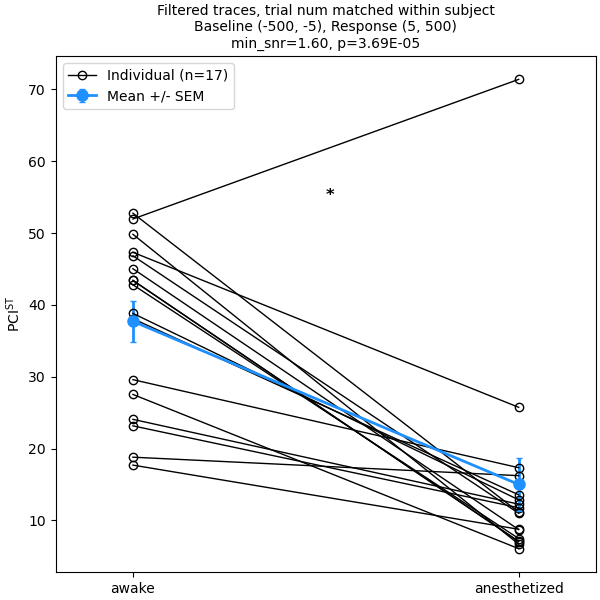

In [16]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn,
    color='k',
    linewidth=1,
    marker='o',
    fillstyle='none'
)
# plot mean +/- SEM with filled circles
mean_sem = ax.errorbar(
    np.arange(0, PCIvalues_eqn.shape[0]),
    np.mean(PCIvalues_eqn, axis=1),
    yerr=stats.sem(PCIvalues_eqn, axis=1),
    color='dodgerblue',
    linewidth=2,
    marker='o',
    markersize=8,
)
# annotate with asterisk
if p2 < 0.01:
    ax.annotate('*', xy=(0.5, 0.72), xycoords='axes fraction', fontsize=12, fontweight='bold')

ax.set_xlim([-0.2, 1.2])
# ax.set_ylim([0, 60])
ax.set_xticks(np.arange(0, PCIvalues_eqn.shape[0]))
ax.set_xticklabels(states)
ax.set_ylabel('$\mathregular{PCI^{ST}}$')
ax.legend([individs[0], mean_sem], [('Individual (n={:d})'.format(PCIvalues_eqn.shape[1])), 'Mean +/- SEM'])
ax.set_title(
    'Filtered traces, trial num matched within subject\nBaseline ({:d}, {:d}), Response ({:d}, {:d})\nmin_snr={:.2f}, p={:.2E}'.format(
        int(PCI_params['baseline_window'][0]*1000),
        int(PCI_params['baseline_window'][1]*1000),
        int(PCI_params['response_window'][0]*1000),
        int(PCI_params['response_window'][1]*1000),
        PCI_params['min_snr'],
        p2
    ))

## Save
figname = 'PCI_awake-anest_B{:d}-{:d}_R{:d}-{:d}_{:d}mice_{}.png'.format(
    int(abs(PCI_params['baseline_window'][0]*1000)),
    int(abs(PCI_params['baseline_window'][1]*1000)),
    int(abs(PCI_params['response_window'][0]*1000)),
    int(abs(PCI_params['response_window'][1]*1000)),
    PCIvalues_eqn.shape[1],
    date.today().strftime('%b%d%Y')
)
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

<IPython.core.display.Javascript object>


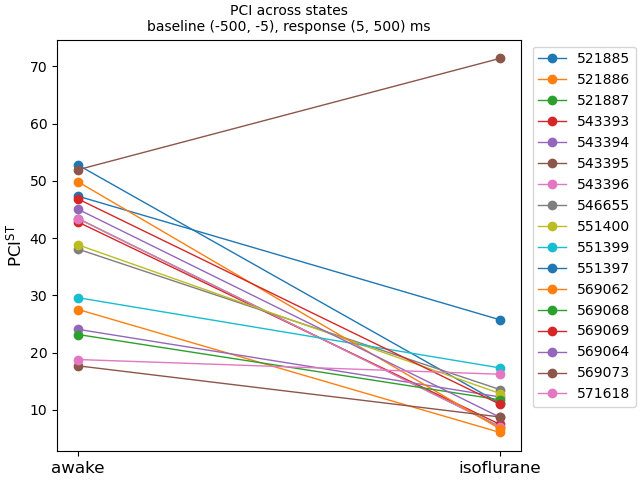

In [18]:
# Plot individuals only ALL STATES
fig, ax = plt.subplots(constrained_layout=True)
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn,
    linewidth=1,
    marker='o',
)

# ax.set_ylim([-2, 60])
ax.set_xticks(np.arange(0, PCIvalues_eqn.shape[0]))
ax.set_xticklabels(['awake', 'isoflurane'], fontsize=12) #, 'recovery\n0-30min', 'recovery\n30-60min'
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
ax.legend(list(pci_eqn.columns), bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_title(
    'PCI across states\nbaseline ({:d}, {:d}), response ({:d}, {:d}) ms'.format(
        int(PCI_params['baseline_window'][0]*1000),
        int(PCI_params['baseline_window'][1]*1000),
        int(PCI_params['response_window'][0]*1000),
        int(PCI_params['response_window'][1]*1000),
    ))

## Save
figname = 'PCIawake-recovery_B{:d}-{:d}_R{:d}-{:d}_{:d}mice_{}multicolor.png'.format(
    int(abs(PCI_params['baseline_window'][0]*1000)),
    int(abs(PCI_params['baseline_window'][1]*1000)),
    int(abs(PCI_params['response_window'][0]*1000)),
    int(abs(PCI_params['response_window'][1]*1000)),
    PCIvalues_eqn.shape[1],
    date.today().strftime('%b%d%Y')
)
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

<IPython.core.display.Javascript object>


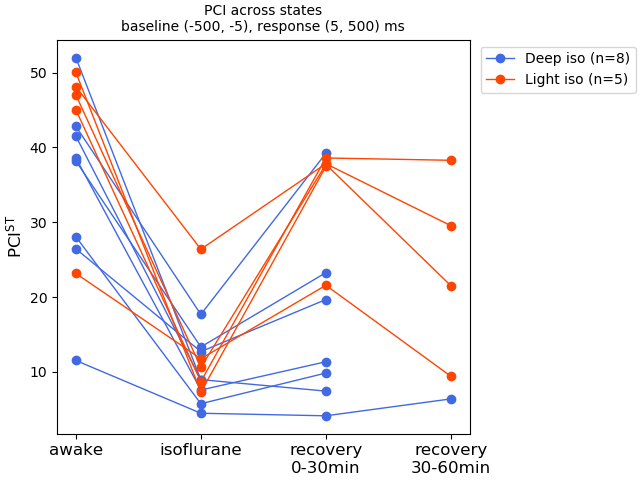

In [28]:
# Plot individuals only ALL STATES - two colors
fig, ax = plt.subplots(constrained_layout=True)
# plot individuals with unfilled circles
inds_deep = ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn[:,:8],
    color='royalblue',
    linewidth=1,
    marker='o',
)
# plot individuals with unfilled circles
inds_low = ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn[:,-5:],
    color='orangered',
    linewidth=1,
    marker='o',
)

# ax.set_ylim([-2, 60])
ax.set_xticks(np.arange(0, PCIvalues_eqn.shape[0]))
ax.set_xticklabels(['awake', 'isoflurane', 'recovery\n0-30min', 'recovery\n30-60min'], fontsize=12)
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
ax.legend([inds_deep[0], inds_low[0]], [('Deep iso (n={:d})'.format(len(inds_deep))), ('Light iso (n={:d})'.format(len(inds_low)))], bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_title(
    'PCI across states\nbaseline ({:d}, {:d}), response ({:d}, {:d}) ms'.format(
        int(PCI_params['baseline_window'][0]*1000),
        int(PCI_params['baseline_window'][1]*1000),
        int(PCI_params['response_window'][0]*1000),
        int(PCI_params['response_window'][1]*1000),
    ))

## Save
figname = 'PCIawake-recovery_B{:d}-{:d}_R{:d}-{:d}_{:d}mice_{}.png'.format(
    int(abs(PCI_params['baseline_window'][0]*1000)),
    int(abs(PCI_params['baseline_window'][1]*1000)),
    int(abs(PCI_params['response_window'][0]*1000)),
    int(abs(PCI_params['response_window'][1]*1000)),
    PCIvalues_eqn.shape[1],
    date.today().strftime('%b%d%Y')
)
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

<IPython.core.display.Javascript object>


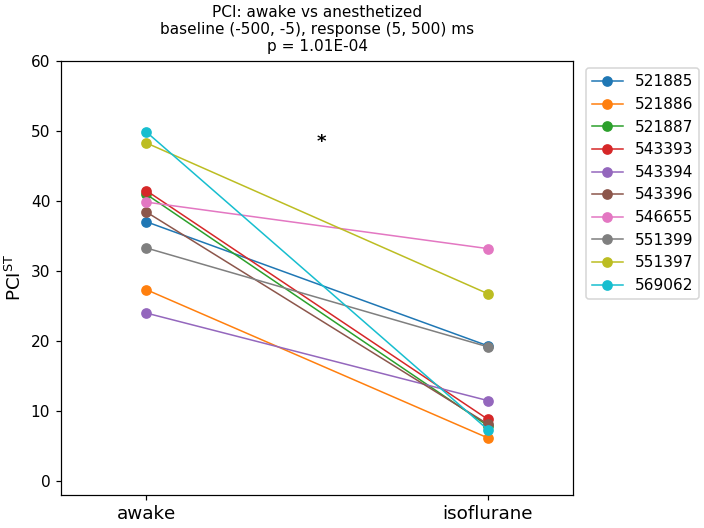

In [25]:
# Plot individuals only - AWAKE & ISO only
fig, ax = plt.subplots(constrained_layout=True)
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, 2),
    PCIvalues_eqn[:2,:],
    linewidth=1,
    marker='o',
)
ax.set_xlim([-0.25, 1.25])
ax.set_ylim([-2, 60])
ax.set_xticks(np.arange(0, 2))
ax.set_xticklabels(['awake', 'isoflurane'], fontsize=12)
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
ax.legend(list(pci_eqn.columns), bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_title(
    'PCI: awake vs anesthetized\nbaseline ({:d}, {:d}), response ({:d}, {:d}) ms\np = {:.2E}'.format(
        int(PCI_params['baseline_window'][0]*1000),
        int(PCI_params['baseline_window'][1]*1000),
        int(PCI_params['response_window'][0]*1000),
        int(PCI_params['response_window'][1]*1000),
        p2
    ))

# annotate with asterisk
if p2 < 0.01:
    ax.annotate('*', xy=(0.5, 0.8), xycoords='axes fraction', fontsize=12, fontweight='bold')

## Save
figname = 'PCIawake-iso_B{:d}-{:d}_R{:d}-{:d}_{:d}mice_{}.png'.format(
    int(abs(PCI_params['baseline_window'][0]*1000)),
    int(abs(PCI_params['baseline_window'][1]*1000)),
    int(abs(PCI_params['response_window'][0]*1000)),
    int(abs(PCI_params['response_window'][1]*1000)),
    PCIvalues_eqn.shape[1],
    date.today().strftime('%b%d%Y')
)
fig.savefig(os.path.join(plotsdir, figname), transparent=True)

## Plotting traces

#### Plot butterfly plots of traces and PCs

<IPython.core.display.Javascript object>


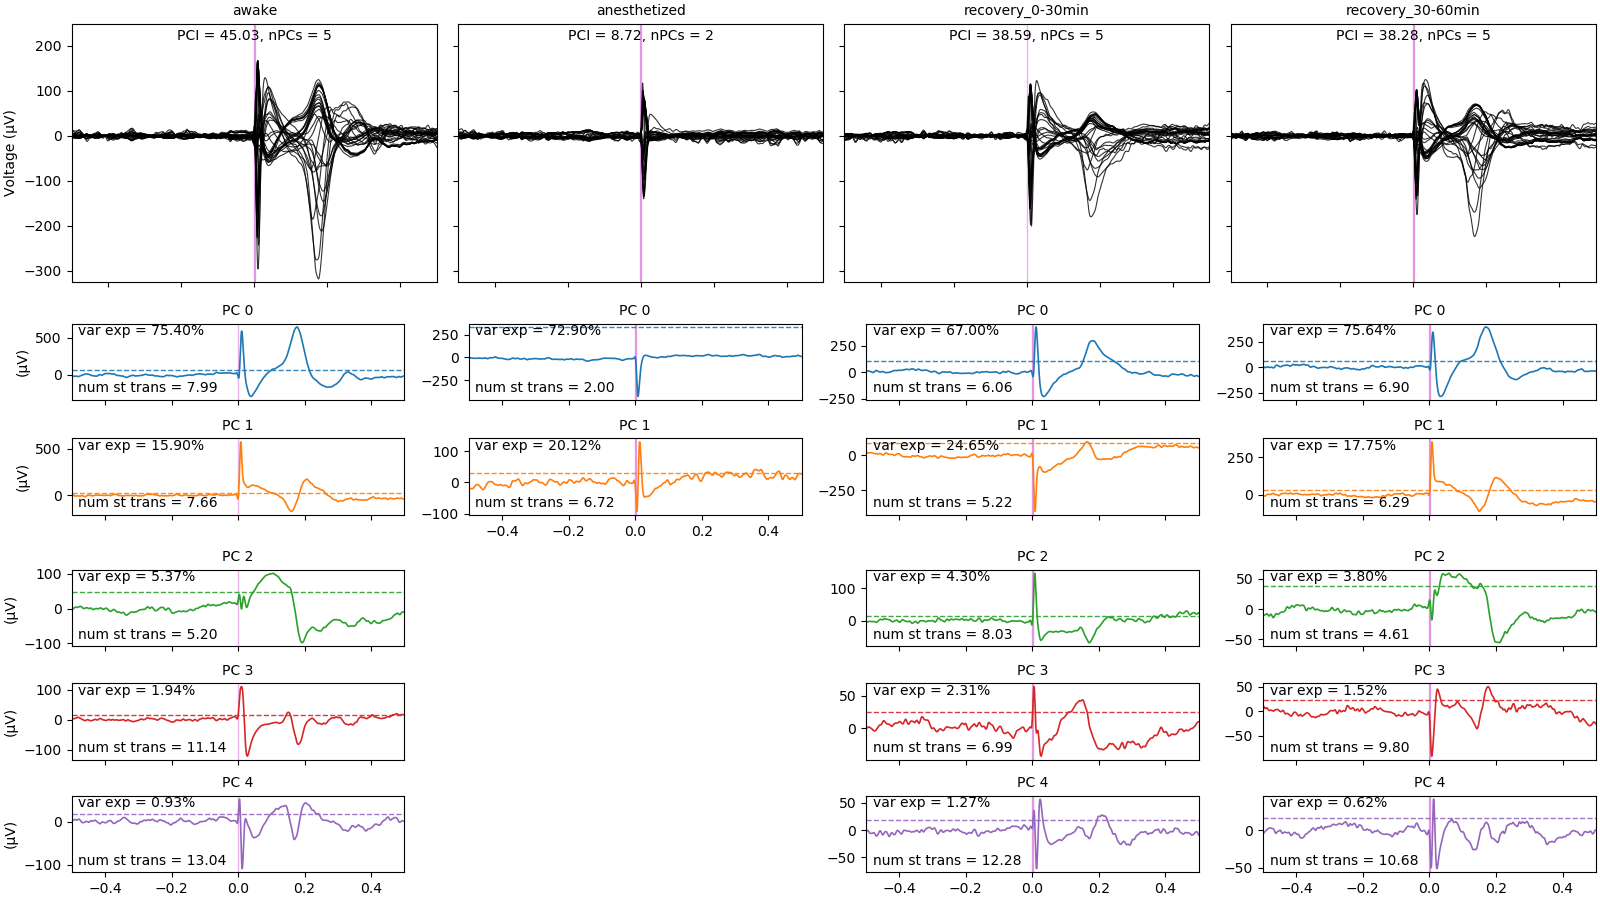

In [59]:
subject = '569064'
plwin = [-0.5, 0.5]

PCcolors = [cm.tab10(x) for x in np.linspace(0, 1, 10)]
max_pcs = max([full_PCI_output[subject][statex]['n_dims'] for statex in full_PCI_output[subject].keys()])

subplotdir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+subject)
if not os.path.exists(subplotdir):
    os.mkdir(subplotdir)

fig = plt.figure(figsize=(16, 9), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=len(avg_traces[subject].keys()), height_ratios=[1,2])
PCgs = gs[1,:].subgridspec(nrows=max_pcs, ncols=len(avg_traces[subject].keys()), hspace=0.05)

for ii, (statei, datadict) in enumerate(avg_traces[subject].items()):
    timex = datadict[0]
    traces = datadict[1][:, sub_good_chs[subject]]
    pinds = np.squeeze(np.argwhere((timex >= plwin[0]) & (timex <= plwin[1])))
    
    ## plot signal traces on top ##
    traceax = fig.add_subplot(gs[0, ii])
    traceax.axvspan(-0.001, 0.001, color='m', alpha=0.3)
    traceax.plot(timex[pinds], traces[pinds,:], color='k', linewidth=0.8, alpha=0.8)
    traceax.set_xlim(plwin)
    traceax.set_ylim([-325, 250])
    traceax.set_title(statei)
    traceax.set_xticklabels([])
    if ii != 0:
        traceax.set_yticklabels([])
    else:
        traceax.set_ylabel('Voltage (\u03bcV)')
    traceax.text(
        0.5, 0.95,
        ('PCI = {:.2f}, nPCs = {:d}'.format(
            full_PCI_output[subject][statei]['PCI'], full_PCI_output[subject][statei]['n_dims'])),
        horizontalalignment='center',
        verticalalignment='center',
        transform=traceax.transAxes
    )
    
    ## plot PCs on bottom ##
    pctimex = full_PCI_output[subject][statei]['times']
    pctraces = full_PCI_output[subject][statei]['signal_svd'].T
    pcinds = np.squeeze(np.argwhere((pctimex >= plwin[0]) & (pctimex <= plwin[1])))
    
    for pci in range(pctraces.shape[1]):
        pcax = fig.add_subplot(PCgs[pci, ii])
        pcax.axvspan(-0.001, 0.001, color='m', alpha=0.3)
        pcax.plot(
            pctimex[pcinds],
            pctraces[pcinds,pci],
            color=PCcolors[pci],
            linewidth=1.2,
            label='pc{:d}: {:.2f}'.format(pci, full_PCI_output[subject][statei]['dNST'][pci])
        )
        pcax.axhline(
            full_PCI_output[subject][statei]['max_thresholds'][pci],
            color=PCcolors[pci], linewidth=1, linestyle='--', alpha=0.9
        )
        pcax.text(
            0.02, 0.9,
            ('var exp = {:.2f}%'.format(full_PCI_output[subject][statei]['var_exp'][pci])),
            horizontalalignment='left', verticalalignment='center', transform=pcax.transAxes, fontsize=10
        )
        pcax.text(
            0.02, 0.15,
            ('num st trans = {:.2f}'.format(full_PCI_output[subject][statei]['dNST'][pci])),
            horizontalalignment='left', verticalalignment='center', transform=pcax.transAxes, fontsize=10
        )
        pcax.set_xlim(plwin)
        pcax.set_title('PC {:d}'.format(pci))
        if ii == 0:
            pcax.set_ylabel('(\u03bcV)')
#         pcax.set_ylim([-500, 600])
#         pcax.set_title('num PCs = {:d}'.format(pctraces.shape[1]))
#         leg = pcax.legend(fontsize=9, loc='upper left', title='pc: var. explained,\nnum st. trans.')
#         plt.setp(leg.get_title(),fontsize='small')
        if pci != pctraces.shape[1]-1:
            pcax.set_xticklabels([])

# axs[0,0].set_ylabel('Voltage (\u03bcV)')
# axs[1,0].set_ylabel('Voltage (\u03bcV)')

## Save butterfly figure ##
figname = 'PCIamp_butterfly_wPCs_allinfo.png'
# fig.savefig(os.path.join(subplotdir, figname), transparent=True)

In [15]:
full_PCI_output[subject][statei].keys()

dict_keys(['PCI', 'dNST', 'n_dims', 'D_base', 'D_resp', 'T_base', 'T_resp', 'thresholds', 'NST_diff', 'NST_resp', 'NST_base', 'max_thresholds', 'signal_evk', 'times', 'signal_svd', 'eigenvalues', 'var_exp', 'snrs'])

In [60]:
print(full_PCI_output[subject]['awake']['var_exp'])
# print(full_PCI_output[subject]['awake']['NST_resp'])

[75.40185736 15.89662477  5.37269663  1.93664135  0.92793412]
[[7.68019742e-03 9.33426308e-03 5.53991095e-03 1.10295007e-02
  1.21731652e-02]
 [7.41094611e-03 8.29712274e-03 5.20073273e-03 1.04883840e-02
  1.22796894e-02]
 [6.96001553e-03 6.87701816e-03 4.98114914e-03 1.01459381e-02
  1.20973566e-02]
 [6.59600345e-03 5.97123586e-03 5.06087890e-03 9.80087820e-03
  1.19150238e-02]
 [6.55417800e-03 5.13864808e-03 4.89945882e-03 9.45581828e-03
  1.17529502e-02]
 [6.54176107e-03 4.91448984e-03 4.99160550e-03 9.18068527e-03
  1.15627751e-02]
 [6.32021692e-03 4.76875430e-03 4.86416860e-03 9.07285404e-03
  1.13026731e-02]
 [6.11827844e-03 4.84913758e-03 4.91252927e-03 8.81536615e-03
  1.10419176e-02]
 [6.03070641e-03 4.74195988e-03 4.72758238e-03 8.11282937e-03
  1.08301763e-02]
 [5.95620484e-03 4.64458501e-03 4.56289469e-03 7.34428681e-03
  1.06210490e-02]
 [5.95685836e-03 4.50799879e-03 4.32697303e-03 6.68618956e-03
  1.04151894e-02]
 [5.80916226e-03 4.45898460e-03 4.06360343e-03 6.38818327e

#### Make butterfly plots for all mice in one figure

In [ ]:
sub_list = ['551399', '551397', '569068']

prex = 0.1 # s before stim to plot
postx = 0.5 # s after stim to plot
bf_ylimit = 0.3 # mV

plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'

# fig, axs = plt.subplots(len(avg_traces.keys()), len(states), figsize=(16, 9), sharex=True, sharey=True)#, constrained_layout=True)
# for row, subject in enumerate(avg_traces.keys()):
fig, axs = plt.subplots(len(sub_list), len(states), figsize=(16, 9), sharex=True, sharey=True, constrained_layout=True)
for row, subject in enumerate(sub_list):
    PCIamp = str(PCI_stim_amp[subject])
    GOOD_CHS = np.array(list(set.intersection(*map(set, [sub_good_chs[subject][PCIamp][x] for x in states if x in estim_traces[subject][PCIamp].keys()]))))

    ## Butterfly figure not including bad chs ##
    for col, statei in enumerate(avg_traces[subject].keys()):
        pick_traces = avg_traces[subject][statei][1]/1000 # or sub_avg_traces_filter
        pick_times = avg_traces[subject][statei][0]
        plot_inds = np.squeeze(np.argwhere((pick_times >= -prex) & (pick_times <= postx)))
        
        axs[row,col].plot(pick_times[plot_inds], pick_traces[plot_inds,:][:, GOOD_CHS], color='k', linewidth=0.6)
        axs[row,col].axvspan(-0.001, 0.001, color='r', alpha=0.25)

        axs[row,col].text(
            0.5, 0.9,
            ('{:s} PCI = {:.2f}'.format(statei, full_PCI_output[subject][statei]['PCI'])),
            horizontalalignment='center',
            verticalalignment='center',
            transform = axs[row,col].transAxes
        )
        if row == 0:
            axs[0,col].set_title(('{:s}'.format(statei)), fontsize=10)
    axs[row,0].set_ylabel('{:s}\n({:d} \u03BCA)\nVoltage (mV)'.format(subject, PCI_stim_amp[subject]))

axs[0,0].set_xlim([-prex, postx])
axs[0,0].set_ylim([-bf_ylimit, bf_ylimit])
# axs[-1,:].set_xlabel('Time from stim onset (ms)')

## Save butterfly figure ##
# fig.savefig(os.path.join(plotsdir, 'evokedEEG_wPCI_awake-recovery_6mice.png'), transparent=True)

#### Plot one mouse, heat maps of all trials

<IPython.core.display.Javascript object>


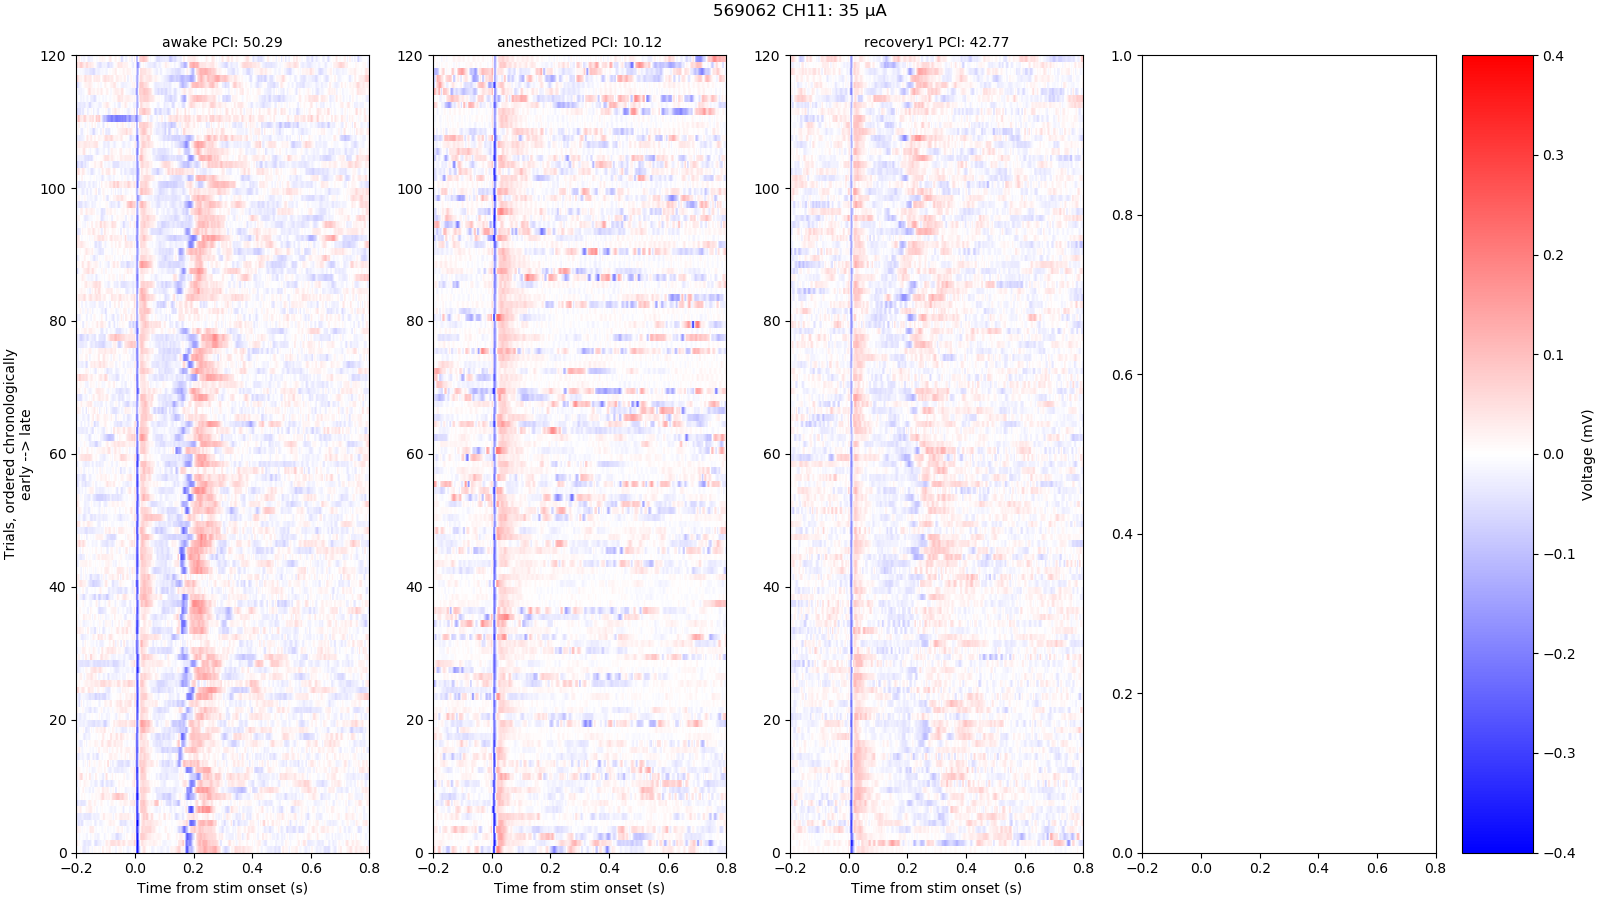

In [23]:
subject = '569062' # '551397' '569062' '551399' '546655'
ampi = '35'
cha = 11

plot_window = [-0.2, 0.8] # s before, after stim to plot
ylimit = 0.4 # mV

## Subject plot directory ##
subsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+subject)
if not os.path.exists(subsavedir):
    os.mkdir(subsavedir)
    
fig, axs = plt.subplots(1, len(states), figsize=(16, 9), sharex=True, constrained_layout=True) #, sharey=True

for ax, statei in zip(axs, states):
    if statei not in estim_traces[subject][ampi].keys():
        continue
    timex = estim_traces[subject][ampi][statei][0]
    alltrials = estim_traces[subject][ampi][statei][1][:, cha, :]
    pinds = np.nonzero((timex >= plot_window[0]) & (timex <= plot_window[1]))[0]

    ## Plot heat map ##
    trials_plot = ax.imshow(
        alltrials[pinds, :].T/1000,
        cmap='bwr',
        aspect='auto',
        interpolation='none',
        origin='lower',
        vmin=-ylimit,
        vmax=ylimit,
        extent=[plot_window[0], plot_window[1], 0, alltrials.shape[1]],
    )

    ax.set_title('{} PCI: {:.2f}'.format(statei, full_PCI_output[subject][statei]['PCI']))
    ax.set_xlabel('Time from stim onset (s)')  

axs[0].set_ylabel('Trials, ordered chronologically\nearly --> late')
cbar = plt.colorbar(trials_plot, ax=ax)
cbar.set_label('Voltage (mV)')

plt.suptitle('{} CH{:d}: {} \u03BCA'.format(subject, cha, ampi))

### SAVE ###
figname = '{}ch{:d}stim{}_chronotrials.png'.format(subject, cha, ampi)
# fig.savefig(os.path.join(subsavedir, figname), transparent=True)

### Calculate PCIst, match trial numbers of states (for all stim amps)

In [11]:
print(multi_amps_mice)

['521885', '521886', '546655', '551399', '551397', '569062', '569068']


In [13]:
states = ['awake', 'anesthetized', 'recovery_0-30min', 'recovery_30-60min']

PCI_params = {
    'baseline_window': (-0.5, -0.005), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.005, 0.5), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

full_PCI_output = {}
avg_traces = {}
for subject in multi_amps_mice:
    print(subject)
    start = time.time()
    
    full_PCI_output[subject] = {}
    avg_traces[subject] = {}
    for ampi in estim_traces[subject].keys():
        print(ampi)
        GOOD_CHS = np.array(list(set.intersection(*map(set, [sub_good_chs[subject][ampi][x] for x in states if x in estim_traces[subject][ampi].keys()]))))
        NUM_TRIALS = min([estim_traces[subject][ampi][x][1].shape[2] for x in states if x in estim_traces[subject][ampi].keys()])
        print('Good channels: {:d}'.format(GOOD_CHS.shape[0]))
        print('Trials: {:d}'.format(NUM_TRIALS))

        full_PCI_output[subject][ampi] = {}
        avg_traces[subject][ampi] = {}
        for statei in states:
            if statei not in estim_traces[subject][ampi].keys():
                continue
            ## Subselect trials and take avg ##
            if statei == 'recovery2': # used to say 'recovery'
                state_traces = np.mean(estim_traces[subject][ampi][statei][1][:, :, -NUM_TRIALS:], axis=2)
            else:
                state_traces = np.mean(estim_traces[subject][ampi][statei][1][:, :, :NUM_TRIALS], axis=2)
            avg_traces[subject][statei] = [estim_traces[subject][ampi][statei][0], state_traces]

            ## Calculate PCIst with full return ##
            full_PCI_output[subject][ampi][statei] = calc_PCIst(
                state_traces[:, GOOD_CHS].T,
                estim_traces[subject][ampi][statei][0],
                full_return=True,
                **PCI_params
            )

            print('{:s} PCI = {:.3f}'.format(statei, full_PCI_output[subject][ampi][statei]['PCI']))
        end = time.time()
        print('Time: {:.2f} s'.format(end-start))
        print('')

521885
20
Good channels: 25
Trials: 60
awake PCI = 4.366
anesthetized PCI = 4.909
Time: 10.18 s

50
Good channels: 25
Trials: 59
awake PCI = 36.982
anesthetized PCI = 19.268
Time: 50.12 s

100
Good channels: 22
Trials: 36
awake PCI = 37.867
anesthetized PCI = 18.485
Time: 95.01 s

521886
20
Good channels: 26
Trials: 98
awake PCI = 20.125
anesthetized PCI = 4.396
recovery_0-30min PCI = 4.483
Time: 25.15 s

50
Good channels: 23
Trials: 98
awake PCI = 27.279
anesthetized PCI = 6.114
recovery_0-30min PCI = 12.538
Time: 60.13 s

100
Good channels: 20
Trials: 94
awake PCI = 32.554
anesthetized PCI = 16.588
recovery_0-30min PCI = 23.637
Time: 105.06 s

546655
50
Good channels: 30
Trials: 117
awake PCI = 39.763
anesthetized PCI = 22.492
recovery_0-30min PCI = 18.408
Time: 50.14 s

70
Good channels: 24
Trials: 100
awake PCI = 39.784
anesthetized PCI = 33.147
recovery_0-30min PCI = 14.361
Time: 105.73 s

90
Good channels: 26
Trials: 58
awake PCI = 43.906
anesthetized PCI = 31.549
Time: 150.55 s


In [23]:
multi_amps_PCI = {'low': {}, 'medium': {}, 'high': {}}
for subject in full_PCI_output.keys():
    for amplevel, ampi in zip(multi_amps_PCI.keys(), sorted(full_PCI_output[subject].keys(), key=int)):
        multi_amps_PCI[amplevel][subject] = {}
        for statei in full_PCI_output[subject][ampi].keys():
            multi_amps_PCI[amplevel][subject][statei] = full_PCI_output[subject][ampi][statei]['PCI']

<IPython.core.display.Javascript object>


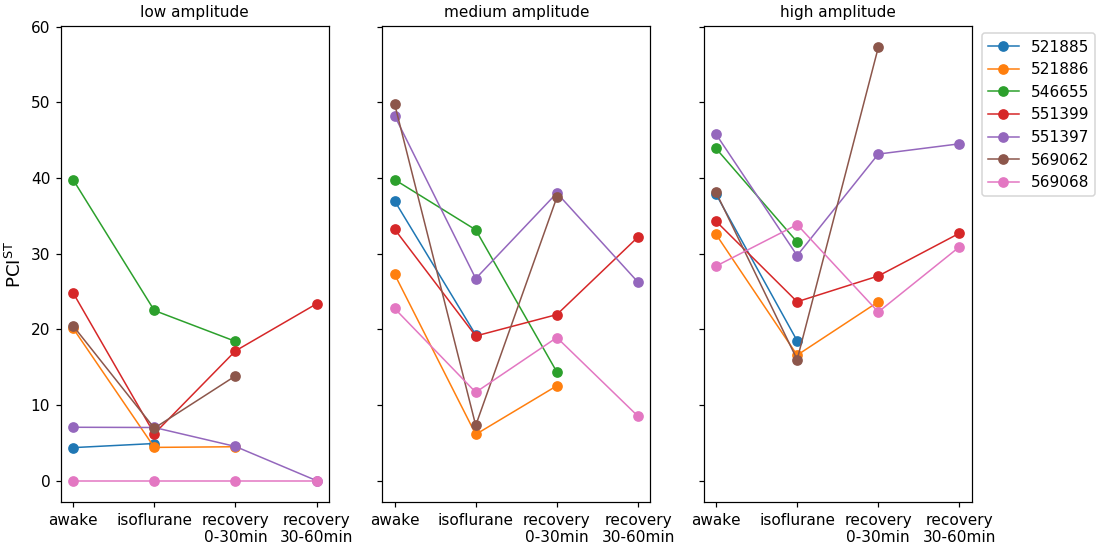

In [30]:
# colormap = plt.cm.gist_rainbow # gist_ncar gist_rainbow
# subcolors = [colormap(i) for i in np.linspace(0, 1, len(multi_amps_mice))]

fig, axs = plt.subplots(1, len(multi_amps_PCI.keys()), figsize=(10,5), sharey=True, constrained_layout=True)

for ax, (amplevel, PCIdict) in zip(axs, multi_amps_PCI.items()):
    pciarray = pd.DataFrame(PCIdict).to_numpy()
    
    individs = ax.plot(
        np.arange(0, pciarray.shape[0]),
        pciarray,
        linewidth=1,
        marker='o',
    )

    # ax.set_ylim([-2, 60])
    ax.set_xticks(np.arange(0, pciarray.shape[0]))
    ax.set_xticklabels(['awake', 'isoflurane', 'recovery\n0-30min', 'recovery\n30-60min'])
    ax.set_title(amplevel + ' amplitude')

axs[0].set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
axs[-1].legend(multi_amps_mice, bbox_to_anchor=(1.01, 1), loc='upper left')
    
## Save ##
figname = 'PCIawake-recovery_B{:d}-{:d}_R{:d}-{:d}_{:d}mice_{}allamps.png'.format(
    int(abs(PCI_params['baseline_window'][0]*1000)),
    int(abs(PCI_params['baseline_window'][1]*1000)),
    int(abs(PCI_params['response_window'][0]*1000)),
    int(abs(PCI_params['response_window'][1]*1000)),
    pciarray.shape[1],
    date.today().strftime('%b%d%Y')
)
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

### Plotting other PCI info

<IPython.core.display.Javascript object>


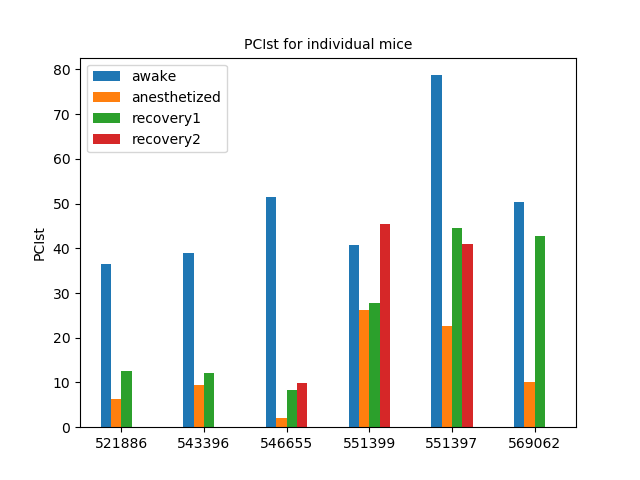

Text(0, 0.5, 'PCIst')

In [30]:
pciax = pci_eqn.T.plot.bar(rot=0)
pciax.set_title('PCIst for individual mice')
pciax.set_ylabel('PCIst')

In [37]:
num_goodchs = [(30 - len(bad_chs[x])) for x in sub_list]
GOOD_CHS = np.array(list(set.intersection(*map(set, [sub_good_chs[subject][x][PCIamp] for x in states if x in estim_traces[subject].keys()]))))
numchsdf = pd.DataFrame({'subjects':sub_list, 'good_chs':num_goodchs})
numchsdf.head()

,subjects,good_chs
0,521885,25
1,521886,23
2,521887,25
3,543393,26
4,543394,21


<IPython.core.display.Javascript object>


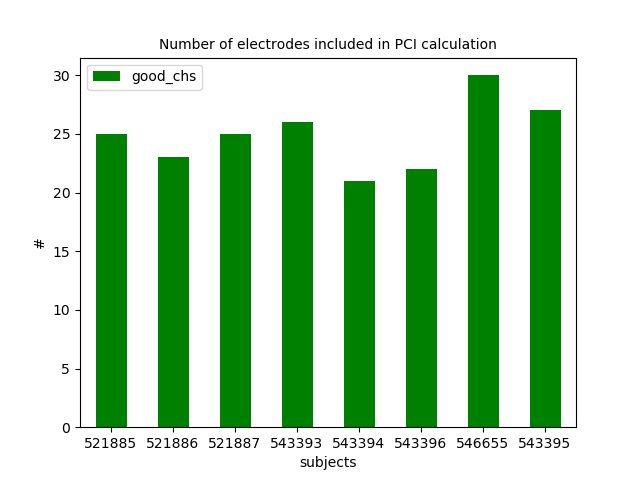

Text(0, 0.5, '#')

In [43]:
numchsax = numchsdf.plot.bar(x='subjects', y='good_chs', rot=0, color='g')
numchsax.set_title('Number of electrodes included in PCI calculation')
numchsax.set_ylabel('#')

In [31]:
## Number of PCs ##
numPCs = {}
for mousei in full_PCI_output.keys():
    numPCs[mousei] = {}
    for statei in full_PCI_output[mousei].keys():
        numPCs[mousei][statei] = full_PCI_output[mousei][statei]['n_dims']
pcdf = pd.DataFrame(numPCs)
pcdf.head()

,521886,543396,546655,551399,551397,569062
awake,3.0,4.0,5,4,5,4.0
anesthetized,2.0,2.0,1,3,3,2.0
recovery1,2.0,2.0,2,3,4,4.0
recovery2,NaN,NaN,1,4,4,NaN


<IPython.core.display.Javascript object>


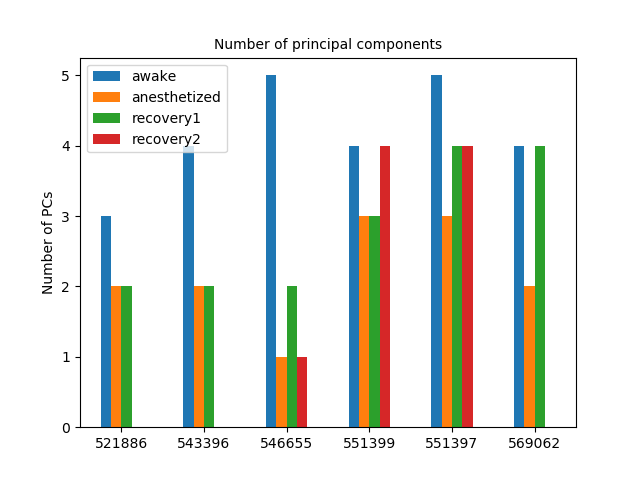

Text(0, 0.5, 'Number of PCs')

In [32]:
pcax = pcdf.T.plot.bar(rot=0)
pcax.set_title('Number of principal components')
pcax.set_ylabel('Number of PCs')

In [33]:
## State transitions ##
state_trans = {}
for mousei in full_PCI_output.keys():
    state_trans[mousei] = {}
    for statei in full_PCI_output[mousei].keys():
        state_trans[mousei][statei] = full_PCI_output[mousei][statei]['dNST']
state_trans = pd.DataFrame(state_trans)
state_trans.head()

,521886,543396,546655,551399,551397,569062
awake,"[12.194875668440861, 13.099698404036033, 11.18...","[10.08094715213071, 8.3935581278309, 6.1524788...","[8.937339779218215, 10.556071618855025, 10.824...","[9.850528434826371, 6.758443359279458, 11.1717...","[10.50457544062193, 16.542938757442002, 18.453...","[9.660146471295514, 14.379087959072082, 15.540..."
anesthetized,"[2.9164569703069954, 3.4323100150981376]","[6.041568358669493, 3.407421434582857]",[2.0402617010568695],"[6.121016099217989, 9.444341829859791, 10.5332...","[6.16748695535307, 10.23312013357604, 6.256287...","[4.907714476469557, 5.21632084517853]"
recovery1,"[4.299394214180163, 8.220056340367174]","[5.769108888393483, 6.32684452945009]","[6.191746351283342, 2.0865626572722697]","[7.129380677460875, 11.357960208760968, 9.3233...","[6.514785735034202, 12.218749505597298, 15.093...","[9.607951685958732, 13.619835240167161, 7.7365..."
recovery2,NaN,NaN,[9.907271769862282],"[11.637966444940831, 9.204726118062613, 15.436...","[9.436839456467036, 10.858066747252604, 11.159...",NaN


<IPython.core.display.Javascript object>


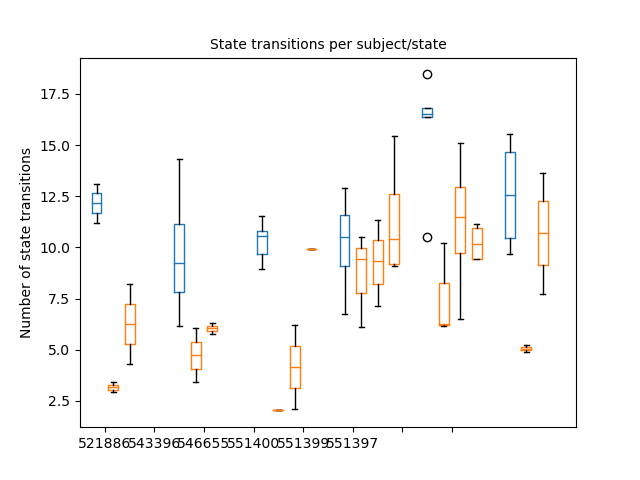

C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\

Text(0.5, 1.0, 'State transitions per subject/state')

In [35]:
fig, ax = plt.subplots()

start = 1
for ii, subject in enumerate(state_trans.keys()):
# for ii, subject in enumerate(sub_list):
    for jj, statei in enumerate(state_trans[subject].keys()):
        if statei == 'awake':
            boxc = '#1f77b4'
        else:
            boxc = '#ff7f0e'
        ax.boxplot(
            state_trans[subject][statei],
            positions=[start],
            widths=0.6,
            boxprops=dict(color=boxc),
            medianprops=dict(color=boxc)
        )
        start += 1
    start += 1

ax.set_xlim(0,start-1)
ax.set_xticklabels(sub_list)
ax.set_xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 22.5])
ax.set_ylabel('Number of state transitions')
ax.set_title('State transitions per subject/state')